# Pipeline Workflow

CausalPy provides a composable pipeline API that chains causal inference steps into a single, reproducible workflow. Instead of manually calling experiment construction, sensitivity analysis, and report generation separately, you can define them as steps in a pipeline.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

import causalpy as cp

## Manual approach (before pipeline)

Traditionally, a CausalPy analysis involves several sequential steps:

In [2]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)
treatment_time = pd.to_datetime("2017-01-01")

model = cp.create_causalpy_compatible_class(LinearRegression())

# Step 1: Fit the experiment
result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t",
    model=model,
)

# Step 2: Get effect summary
summary = result.effect_summary()
print(summary.text)

Post-period (2017-01-31 00:00:00 to 2019-12-31 00:00:00), the average effect was 1.05 (95% CI [-2.94, 5.04]), with a p-value of 0.598. The cumulative effect was 37.71 (95% CI [-105.99, 181.42]); p-value 0.598. Relative to the counterfactual, this equals 1.94% on average (95% CI [-5.27%, 9.14%]).


## Pipeline approach

The pipeline wraps these steps into a single, declarative workflow. Each step is configured upfront, and the pipeline validates everything before running.

In [3]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

result = cp.Pipeline(
    data=df,
    steps=[
        cp.EstimateEffect(
            method=cp.InterruptedTimeSeries,
            treatment_time=pd.to_datetime("2017-01-01"),
            formula="y ~ 1 + t",
            model=cp.create_causalpy_compatible_class(LinearRegression()),
        ),
        cp.GenerateReport(include_plots=False),
    ],
).run()

print("Experiment type:", type(result.experiment).__name__)
print("Effect summary available:", result.effect_summary is not None)
print("Report generated:", result.report is not None)

Experiment type: InterruptedTimeSeries
Effect summary available: True
Report generated: True


## Adding sensitivity analysis

The `SensitivityAnalysis` step runs a suite of diagnostic checks against the fitted experiment. Checks are pluggable, and you can choose which ones to run.

In [4]:
result = cp.Pipeline(
    data=df,
    steps=[
        cp.EstimateEffect(
            method=cp.InterruptedTimeSeries,
            treatment_time=pd.to_datetime("2017-01-01"),
            formula="y ~ 1 + t",
            model=cp.create_causalpy_compatible_class(LinearRegression()),
        ),
        cp.SensitivityAnalysis(
            checks=[
                cp.checks.PlaceboInTime(n_folds=2),
            ]
        ),
        cp.GenerateReport(include_plots=True),
    ],
).run()

print(f"Sensitivity checks run: {len(result.sensitivity_results)}")
for check_result in result.sensitivity_results:
    print(f"  - {check_result.check_name}: {check_result.text[:80]}...")

Sensitivity checks run: 1
  - PlaceboInTime: Placebo-in-time analysis: 2 of 2 folds completed.
FAILED — 1 of 2 fold(s) detect...


## Available checks

CausalPy provides a range of sensitivity checks, each applicable to specific experiment types:

| Check | Applicable methods | Description |
|-------|-------------------|-------------|
| `PlaceboInTime` | ITS, SC | Shifts treatment time backward to test for spurious effects |
| `PriorSensitivity` | All Bayesian | Re-fits with different priors |
| `ConvexHullCheck` | SC | Validates treated values are within control range |
| `PersistenceCheck` | ITS (3-period) | Checks if effects persist after intervention ends |
| `PreTreatmentPlaceboCheck` | Staggered DiD | Validates parallel trends via pre-treatment effects |
| `BandwidthSensitivity` | RD, RKink | Re-fits with multiple bandwidths |
| `LeaveOneOut` | SC | Drops each control unit and refits |
| `PlaceboInSpace` | SC | Treats each control as placebo treated |
| `McCraryDensityTest` | RD | Tests for running variable manipulation |

## Pipeline result

The `PipelineResult` object contains all accumulated outputs:

In [5]:
print("result.experiment      ->", type(result.experiment).__name__)
print("result.effect_summary  ->", type(result.effect_summary).__name__)
print("result.sensitivity_results ->", len(result.sensitivity_results), "checks")
print("result.report          ->", "HTML" if result.report else "None")

result.experiment      -> InterruptedTimeSeries
result.effect_summary  -> EffectSummary
result.sensitivity_results -> 1 checks
result.report          -> HTML


The effect summary provides both a table and prose:

In [6]:
if result.effect_summary is not None:
    print(result.effect_summary.text)
    display(result.effect_summary.table)

Post-period (2017-01-31 00:00:00 to 2019-12-31 00:00:00), the average effect was 1.05 (95% CI [-2.94, 5.04]), with a p-value of 0.598. The cumulative effect was 37.71 (95% CI [-105.99, 181.42]); p-value 0.598. Relative to the counterfactual, this equals 1.94% on average (95% CI [-5.27%, 9.14%]).


,mean,ci_lower,ci_upper,p_value,relative_mean,relative_ci_lower,relative_ci_upper
average,1.047516,-2.944286,5.039319,0.597584,1.938469,-5.265065,9.142003
cumulative,37.710592,-105.994305,181.415488,0.597584,69.784884,-189.542323,329.112091


## Viewing the HTML report

The `GenerateReport` step renders the full analysis — effect summary, diagnostic plots, and sensitivity-check results — into a single HTML report stored in `result.report`. See the {doc}`report generation notebook <report_demo>` for the standalone (non-pipeline) API.


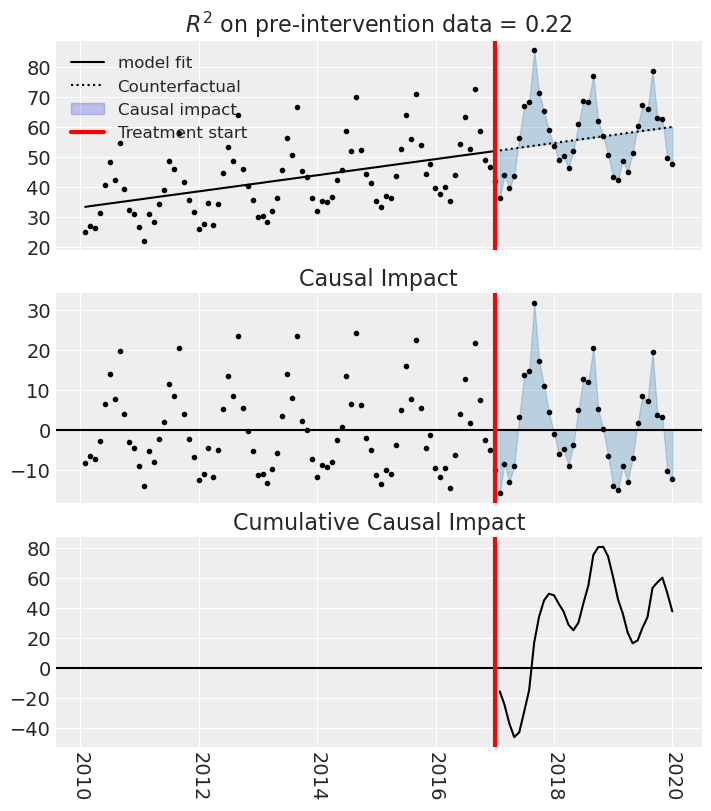

In [7]:
import html as html_module
import warnings

from IPython.display import HTML

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", "Consider using IPython.display.IFrame", UserWarning
    )
    report_widget = HTML(
        '<iframe srcdoc="'
        + html_module.escape(result.report)
        + '" width="100%" height="1000"'
        ' style="border: 1px solid #ddd; border-radius: 6px;"></iframe>'
    )
report_widget